# Problem Statement
Ninjacart is India's largest fresh produce supply chain company. They use innovative technology to solve complex supply chain challenges. They collect fresh produce from farmers and deliver it to businesses within 12 hours. A key part of their automation is building strong classifiers that can identify different types of vegetables in images and label images without a specific vegetable as noise.

The goal is to create a program that can identify vegetable items in an image and provide the correct classification to the user.

* Approach:
  - Preparing and visualizing the dataset  
  - Building and training CNN models  
  - Using callbacks to optimize training  
  - Handling overfitting effectively  
  - Applying transfer learning(ResNet,VGGNet) for better accuracy  

In [1]:
!gdown 1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT

Downloading...
From (original): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT
From (redirected): https://drive.google.com/uc?id=1clZX-lV_MLxKHSyeyTheX5OCQtNCUcqT&confirm=t&uuid=e64e3e41-8481-46ec-b99f-0e033ba3deb4
To: /content/ninjacart_data.zip
100% 275M/275M [00:10<00:00, 26.6MB/s]


In [2]:
!unzip -q ninjacart_data.zip

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
import sklearn.metrics as metrics
import numpy as np
import seaborn as sns
from tensorflow.keras import optimizers #used Adam optimizer

Total Classes :  ['tomato', 'potato', 'indian market', 'onion']
Training - Total Images : 
 {'tomato': 789, 'potato': 898, 'indian market': 599, 'onion': 849}
Test - Total Images : 
 {'tomato': 106, 'potato': 81, 'indian market': 81, 'onion': 83}


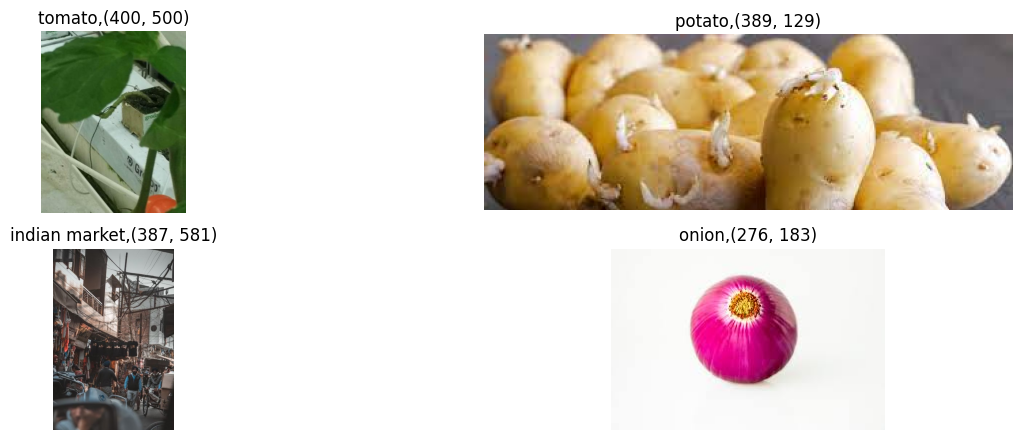

In [4]:
class_dirs = os.listdir("/content/ninjacart_data/train") # list all directories inside "train" folder
image_dict = {} # dict to store image array(key) for every class(value)
count_dict = {} # dict to store count of files(key) for every class(value)
count_dict_test={}
print('Total Classes : ',class_dirs)
# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'/content/ninjacart_data/train/{cls}/*')
    #print(file_paths)
    count_dict[cls]=len(file_paths)
    image_path=random.choice(file_paths)
    image_dict[cls]=tf.keras.utils.load_img(image_path)

print('Training - Total Images : \n',count_dict)

#print(image_dict.keys())
plt.figure(figsize=(15,8))
for i,(cls,img) in enumerate(image_dict.items()):
  plt.subplot(3,2,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'{cls},{img.size}')
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'/content/ninjacart_data/test/{cls}/*')
    count_dict_test[cls]=len(file_paths)

print('Test - Total Images : \n',count_dict_test)

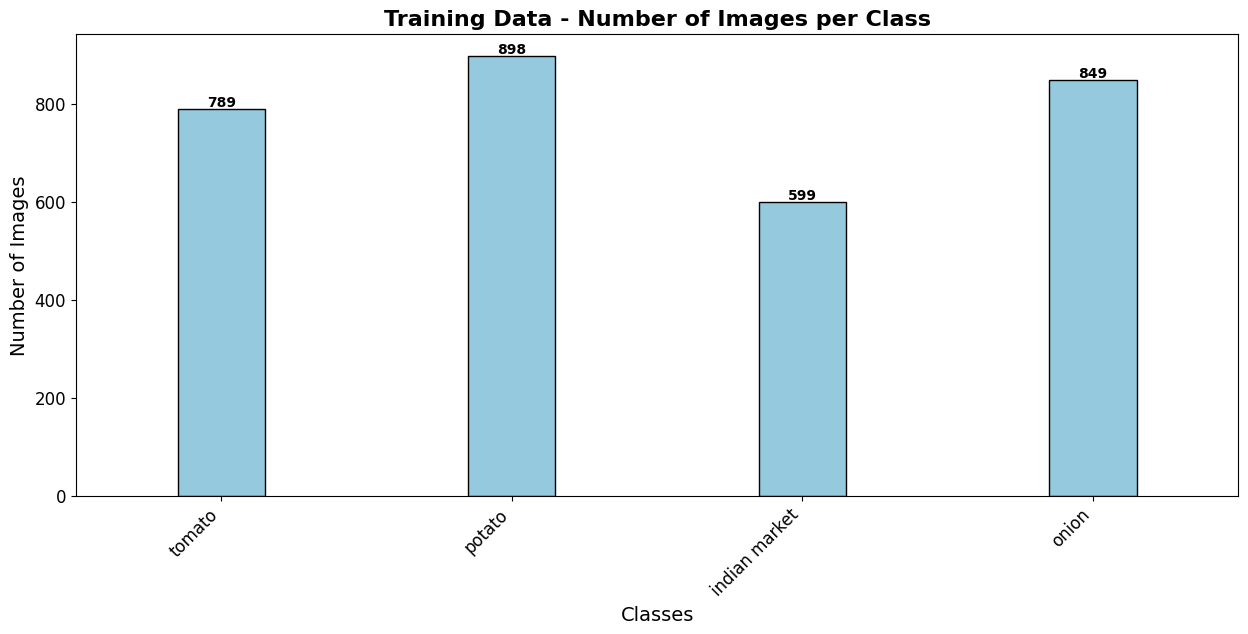

In [5]:
plt.figure(figsize=(15, 6))
sns.barplot(x=list(count_dict.keys()), y=list(count_dict.values()), color='skyblue', edgecolor='black', width=0.3)
plt.title('Training Data - Number of Images per Class', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Annotate bars with their values
for i, v in enumerate(count_dict.values()):
    plt.text(i, v + 5, str(v), ha='center', fontsize=10, fontweight='bold')

plt.show()

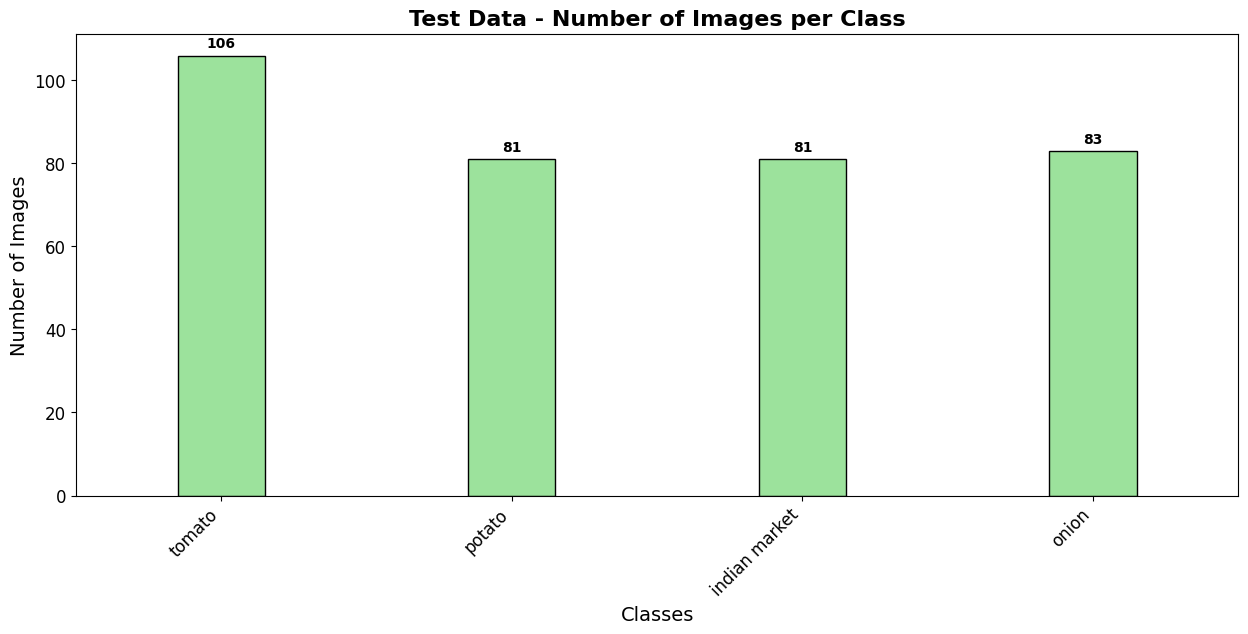

In [6]:
plt.figure(figsize=(15, 6))
sns.barplot(x=list(count_dict_test.keys()), y=list(count_dict_test.values()), color='lightgreen', edgecolor='black', width=0.3)
plt.title('Test Data - Number of Images per Class', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Annotate bars with their values
for i, v in enumerate(count_dict_test.values()):
    plt.text(i, v + 2, str(v), ha='center', fontsize=10, fontweight='bold')

plt.show()

* There is no imbalance between the classes either in Training or Test dataset.

# Mounting the Dataset

* Till now we explored the data, observed the distribution of the classes and imbalance between them.
* In order to feed this data to Model,
    * Each image has to be lebelled
    * It should be a tensor
* There will be 3 splits of data
    * Train
    * Test
    * Validation

* For these tasks we will use tf.keras.utils.image_dataset_from_directory, which will perform following operations:
    1. Creates image and label pair for each image
      - It will perform one hot encoding alpabatically ie. The image in the Indian Market directory will be labelled as [1,0,0,0]
    2. Batching images together
    3. Resize the images
    4. Seeds the shuffling, so that images shuffle in "fixed" way
    5. Performs train, test and validation split

In [7]:
train_dir = '/content/ninjacart_data/train'
test_dir = '/content/ninjacart_data/test'

In [8]:
train_data = tf.keras.utils.image_dataset_from_directory(directory = train_dir,
                                                         label_mode = "categorical",
                                                         batch_size = 32,
                                                         image_size = (256,256),
                                                         shuffle = True,
                                                         seed = 42,
                                                         validation_split = 0.2,
                                                         subset = "training")

Found 3135 files belonging to 4 classes.
Using 2508 files for training.


In [9]:
test_data = tf.keras.utils.image_dataset_from_directory(directory = test_dir,
                                                         label_mode = "categorical",
                                                         batch_size = 32,
                                                         image_size = (256,256),
                                                         seed = 42)

Found 351 files belonging to 4 classes.


In [10]:
valid_ds = tf.keras.utils.image_dataset_from_directory(directory = train_dir,
                                                         label_mode = "categorical",
                                                         batch_size = 32,
                                                         image_size = (256,256),
                                                         seed = 42,
                                                         validation_split = 0.2,
                                                         subset = "validation")

Found 3135 files belonging to 4 classes.
Using 627 files for validation.


* Since label_mode = "categorical" one-hot encodes the classes alphabetically.

In [11]:
class_names = ["noise", "onion", "potato", "tomato"]

# Building Custom CNN Model

1. CNN Architecture with some Convolutional Blocks with MaxPooling

In [12]:
image_size = [256,256]

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(image_size[0], image_size[1], 3)),
    tf.keras.layers.Rescaling(1./255),  # Rescaling should be after InputLayer

    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(4, activation="softmax")
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ["accuracy","Precision","Recall"])

## Model Training
* Implementing tesorboard callback to plot our model's metrices

In [15]:
log_dir_1 = "logs/Custom_CNN_overfit"
tensorboard_callback_1 = tf.keras.callbacks.TensorBoard(log_dir = log_dir_1, histogram_freq = 1)

In [16]:
history = model.fit(train_data, epochs = 20, validation_data = valid_ds, callbacks = [tensorboard_callback_1])

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 342ms/step - Precision: 0.4075 - Recall: 8.9559e-04 - accuracy: 0.2996 - loss: 1.3543 - val_Precision: 0.8125 - val_Recall: 0.0622 - val_accuracy: 0.5040 - val_loss: 1.1616
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - Precision: 0.8015 - Recall: 0.1582 - accuracy: 0.5777 - loss: 1.0794 - val_Precision: 0.8333 - val_Recall: 0.4466 - val_accuracy: 0.6683 - val_loss: 0.8748
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - Precision: 0.8358 - Recall: 0.5120 - accuracy: 0.7130 - loss: 0.7982 - val_Precision: 0.7853 - val_Recall: 0.5949 - val_accuracy: 0.7033 - val_loss: 0.7636
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - Precision: 0.8086 - Recall: 0.6061 - accuracy: 0.7247 - loss: 0.7161 - val_Precision: 0.7793 - val_Recall: 0.6252 - val_accuracy: 0.7209 - val_loss: 0.7040
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 167ms/step - Precision: 0.8250 - Recall: 0.6615 - accuracy: 0.7560 - loss: 0.6747 - val_Precision: 0.7591 - va

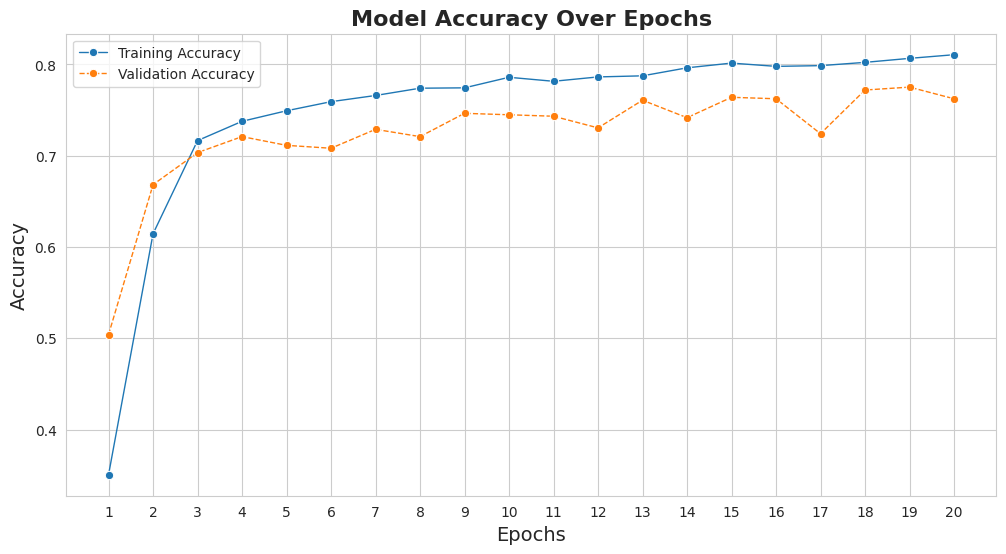

In [17]:
epochs = range(1, len(history.history['accuracy']) + 1)

# Create DataFrame for Seaborn
df = pd.DataFrame({
    "Epoch": epochs,
    "Training Accuracy": history.history['accuracy'],
    "Validation Accuracy": history.history['val_accuracy'],
    "Training Loss": history.history['loss'],
    "Validation Loss": history.history['val_loss']
})

# Set Seaborn style
sns.set_style("whitegrid")

# Plot Accuracy vs. Epochs
plt.figure(figsize=(12, 6))
sns.lineplot(x="Epoch", y="Training Accuracy", data=df, label="Training Accuracy", marker="o", linewidth=1)
sns.lineplot(x="Epoch", y="Validation Accuracy", data=df, label="Validation Accuracy", marker="o", linestyle="--", linewidth=1)

plt.xticks(ticks=epochs, labels=[str(e) for e in epochs])  # Ensure integer epochs
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Model Accuracy Over Epochs", fontsize=16, fontweight="bold")
plt.legend()
plt.show()

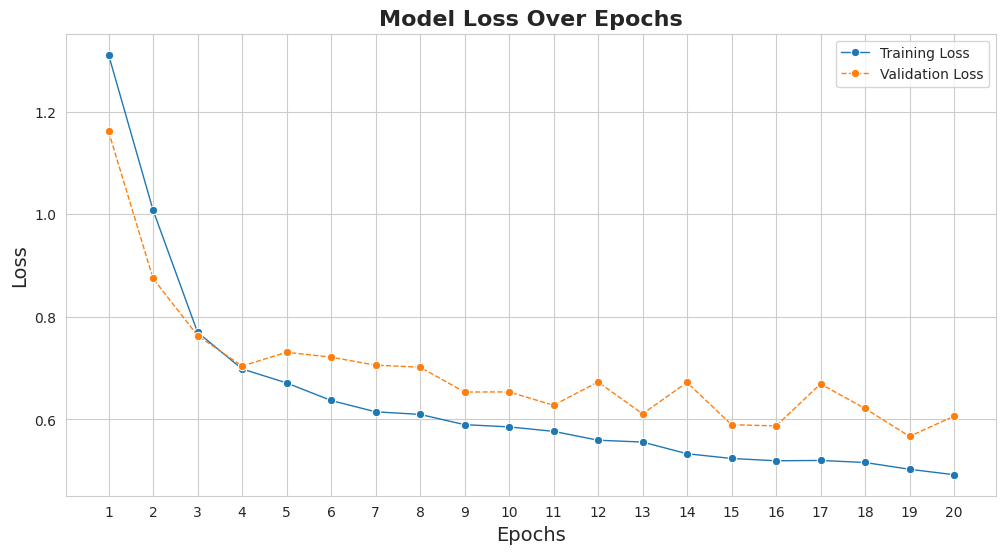

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(x="Epoch", y="Training Loss", data=df, label="Training Loss", marker="o", linewidth=1)
sns.lineplot(x="Epoch", y="Validation Loss", data=df, label="Validation Loss", marker="o", linestyle="--", linewidth=1)

plt.xticks(ticks=epochs, labels=[str(e) for e in epochs])  # Ensure integer epochs
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Model Loss Over Epochs", fontsize=16, fontweight="bold")
plt.legend()
plt.show()

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 419,822 (1.60 MB)

 Trainable params: 139,940 (546.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 279,882 (1.07 MB)

## Testing the model

In [20]:
#creating test_images list made of random unseen images
test_images = []

for folder in os.listdir(test_dir):
    for image in os.listdir(test_dir + '/' + folder):
        test_images.append(os.path.join(test_dir, folder, image))

#### Random Sample Testing
  * Read a random image from test_images list containing paths of all test images
  * Resize an image to (256,256)
  * Add an extra dimension to our image's first dimension index
  * Predict on the image using model.perdict()

In [21]:
def grid_test_model(model_name):

  fig = plt.figure(figsize=(15, 15))
  plt.axis("off")
  n = 0
  for i in range(8):
    n += 1

    img_0 = tf.keras.utils.load_img(random.choice(test_images))
    img_0 = tf.keras.utils.img_to_array(img_0)
    img_0 = tf.image.resize(img_0, (256,256))
    img_1 = np.expand_dims(img_0, axis=0)

    prediction = model_name.predict(img_1)
    prediction_class = tf.argmax(prediction, axis=1).numpy().item()

    for item in prediction:
      item = tf.round(item*100)

    plt.subplot(2,4,n)
    plt.axis('off')
    plt.title(f'Prediction : {class_names[prediction_class]}\n\n'
    f'{item[0]} % {class_names[0]}\n'
    f'{item[1]} % {class_names[1]}\n'
    f'{item[2]} % {class_names[2]}\n'
    f'{item[3]} % {class_names[3]}\n')
    plt.imshow(img_0/255.)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


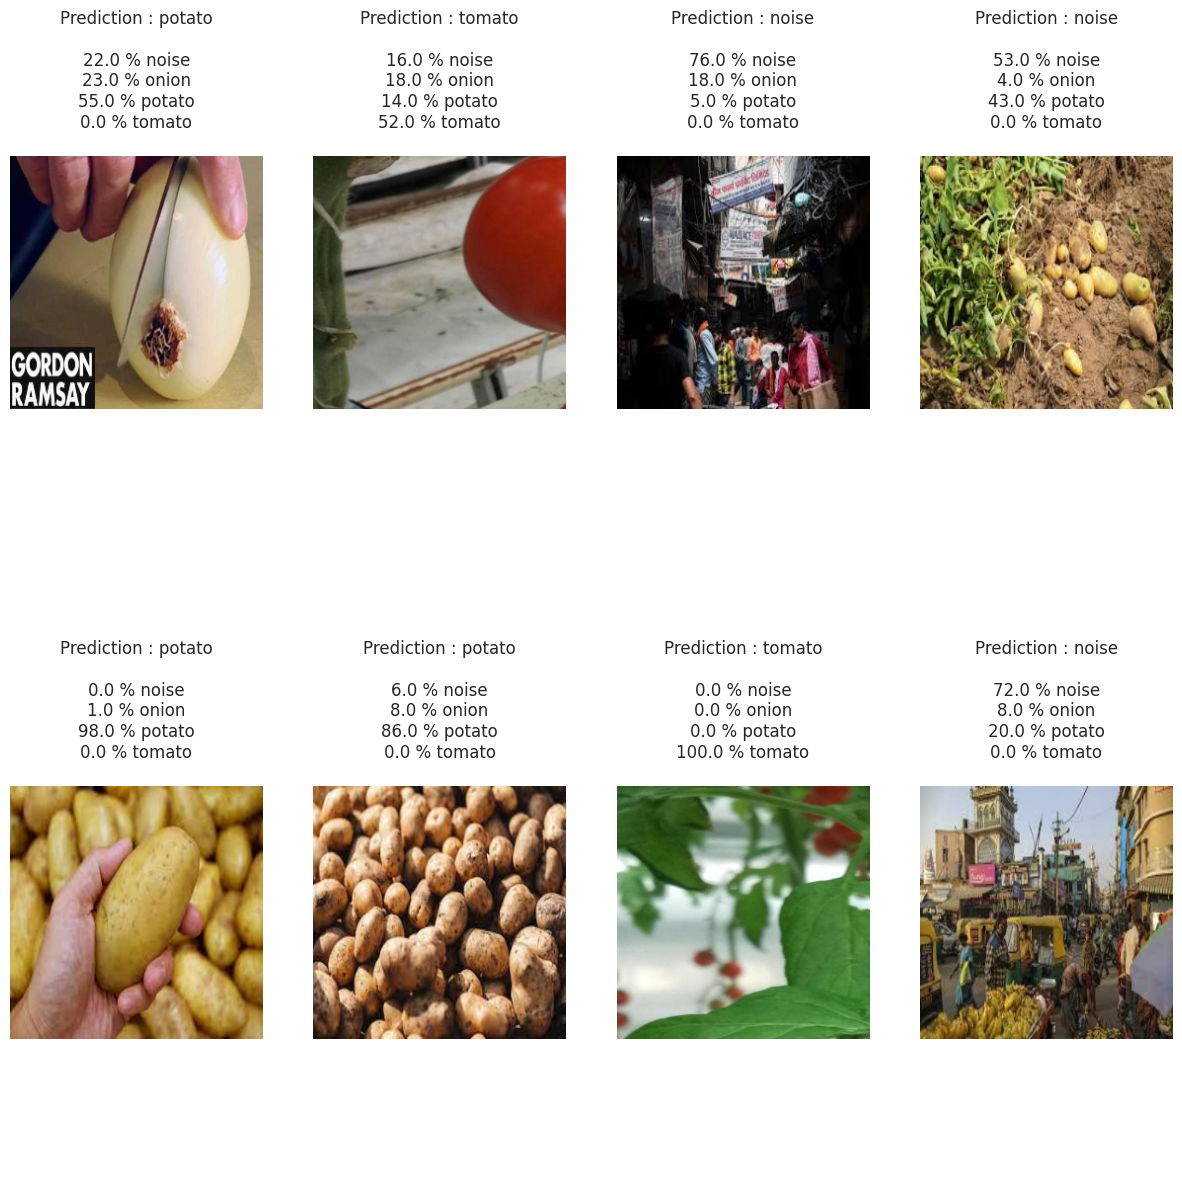

In [22]:
grid_test_model(model)

### Evaluating accuracy on each class

In [23]:
#test data for each class
noise_test_path = "/content/ninjacart_data/test/indian market"
onion_test_path = "/content/ninjacart_data/test/onion"
potato_test_path = "/content/ninjacart_data/test/potato"
tomato_test_path = "/content/ninjacart_data/test/tomato"

In [24]:
def classwise_accuracy(class_path, class_name, model, class_names):
    paths = [os.path.join(class_path, i) for i in os.listdir(class_path)]

    correct = 0
    total = len(paths)

    for path in paths:
        img = tf.keras.utils.load_img(path)
        img = tf.keras.utils.img_to_array(img)
        img = tf.image.resize(img, (256, 256))
        img = np.expand_dims(img, axis=0)

        prediction = model.predict(img,verbose = 0)
        predicted_class = tf.argmax(prediction, axis=1).numpy().item()

        if predicted_class == class_names.index(class_name):
            correct += 1

    accuracy = round((correct * 100 / total), 2) if total > 0 else 0
    print(f"Accuracy for class {class_name} is {accuracy}% consisting of {total} images.")

In [25]:
class_names = ["noise", "onion", "potato", "tomato"]
classwise_accuracy(noise_test_path, "noise", model, class_names)
classwise_accuracy(onion_test_path, "onion", model, class_names)
classwise_accuracy(potato_test_path, "potato", model, class_names)
classwise_accuracy(tomato_test_path, "tomato", model, class_names)


Accuracy for class noise is 85.19% consisting of 81 images.
Accuracy for class onion is 46.99% consisting of 83 images.
Accuracy for class potato is 75.31% consisting of 81 images.
Accuracy for class tomato is 95.28% consisting of 106 images.


### Plotting the confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
def plot_confusion_matrix(test_paths, class_names, model):
    y_true = []
    y_pred = []

    for class_idx, class_path in enumerate(test_paths):
        paths = [os.path.join(class_path, i) for i in os.listdir(class_path)]

        for path in paths:
            img = tf.keras.utils.load_img(path)
            img = tf.keras.utils.img_to_array(img)
            img = tf.image.resize(img, (256, 256))
            img = np.expand_dims(img, axis=0)

            prediction = model.predict(img, verbose=0)
            predicted_class = tf.argmax(prediction, axis=1).numpy().item()

            y_true.append(class_idx)  # Actual class index
            y_pred.append(predicted_class)  # Predicted class index

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)


    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

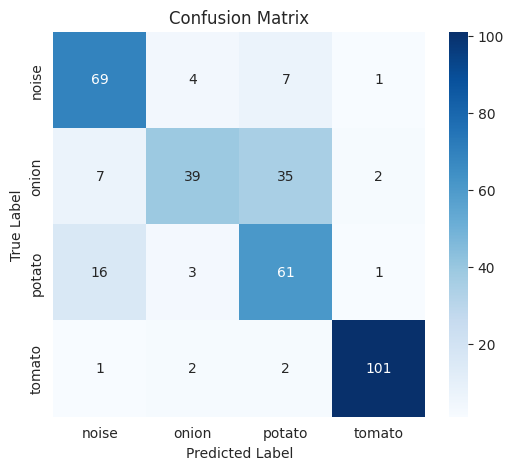

In [28]:
test_paths = [noise_test_path, onion_test_path, potato_test_path, tomato_test_path]
class_names = ["noise", "onion", "potato", "tomato"]

plot_confusion_matrix(test_paths, class_names, model)


1. **Strong Performance for 'Tomato' Class**  
   - The model classified **101 instances** correctly as 'tomato'.  
   - Very few misclassifications: 1 as 'noise', 2 as 'onion', and 2 as 'potato'.  

2. **Decent Performance for 'Noise' Class**  
   - **69 instances** correctly classified as 'noise'.  
   - Some misclassifications: 4 as 'onion', 7 as 'potato', and 1 as 'tomato'.  
   - The model confuses 'noise' with 'potato' more than with other classes.  

3. **Confusion Between 'Onion' and 'Potato'**  
   - 'Onion' was correctly classified **39 times**, but misclassified **35 times as 'potato'**, suggesting the model struggles to differentiate between these two classes.  
   - 'Potato' was correctly classified **61 times**, but **16 instances were misclassified as 'noise'**.  

4. **General Observation**  
   - The model performs well overall, especially for 'tomato' and 'noise'.  
   - It struggles with distinguishing 'onion' and 'potato', leading to significant misclassification between these two classes.  

* The accuracy for Onion and Potato is not significant.
* Tuning the model to get significant accuracies for these two classes.

## Model Tuning

### Data Augmentation
* Data augmentation is a technique that uses existing data to create new data samples
* Data augmentation can involve making small changes to existing data, such as flipping, cropping, rotating, or scaling.
* There are 3 types of augmentation
  * RandomRotation : Rotates images randomly during training by a factor
  * RandomFlip : Randomly flips images horizontally as well as vertically during training.
  * RandomTranslation : Randomly translates images during training by a shift factor


In [29]:
augmentation  = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(height_factor = 0.2, width_factor = 0.2)
])

In [30]:
aug_data = train_data
for image,label in aug_data:
  image = augmentation(image)


## Applying Batch Normalization and Dropout

In [31]:


model_revamp = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(image_size[0], image_size[1], 3)),
    tf.keras.layers.Rescaling(1./255),  # Normalize pixel values

    # First Conv Block
    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    # Second Conv Block
    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    # Third Conv Block
    tf.keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    tf.keras.layers.BatchNormalization(),

    # Global Pooling & Fully Connected Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),  # Dropout applied only in the last layer
    tf.keras.layers.Dense(4, activation="softmax")  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [32]:
model_revamp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


## Implementing Callbacks
 * Early Stopping
 * Checkpoint
 * TensorBoard

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [34]:
# Define Callbacks
log_dir_2 = "logs/Custom_CNN_revamp"

In [35]:
# Early Stopping: Monitors 'val_loss' with patience = 5
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [36]:
# Model Checkpoint: Saves the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    "CNN_best_5.h5",  # Saves the model as 'CNN_best_5.h5'
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [37]:
# TensorBoard Callback: Logs training details for visualization
tensorboard_callback = TensorBoard(log_dir=log_dir_2)

## Training the Tuned Model

In [38]:
# Compile Callbacks
callbacks = [early_stopping, model_checkpoint, tensorboard_callback]

# Train Model
history = model_revamp.fit(
    train_data,
    validation_data= valid_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6476 - loss: 0.8744 - precision_1: 0.7685 - recall_1: 0.4742
Epoch 1: val_loss improved from inf to 1.42451, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 264ms/step - accuracy: 0.6486 - loss: 0.8724 - precision_1: 0.7691 - recall_1: 0.4760 - val_accuracy: 0.4434 - val_loss: 1.4245 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7916 - loss: 0.5518 - precision_1: 0.8397 - recall_1: 0.7269
Epoch 2: val_loss improved from 1.42451 to 1.40036, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.7917 - loss: 0.5516 - precision_1: 0.8398 - recall_1: 0.7271 - val_accuracy: 0.4912 - val_loss: 1.4004 - val_precision_1: 0.5416 - val_recall_1: 0.3222
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8149 - loss: 0.5010 - precision_1: 0.8527 - recall_1: 0.7593
Epoch 3: val_loss improved from 1.40036 to 1.16890, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.8150 - loss: 0.5008 - precision_1: 0.8527 - recall_1: 0.7594 - val_accuracy: 0.5215 - val_loss: 1.1689 - val_precision_1: 0.6018 - val_recall_1: 0.4338
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8424 - loss: 0.4464 - precision_1: 0.8718 - recall_1: 0.8032
Epoch 4: val_loss improved from 1.16890 to 1.00631, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.8423 - loss: 0.4465 - precision_1: 0.8717 - recall_1: 0.8031 - val_accuracy: 0.5901 - val_loss: 1.0063 - val_precision_1: 0.6407 - val_recall_1: 0.5120
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8399 - loss: 0.4333 - precision_1: 0.8802 - recall_1: 0.7988
Epoch 5: val_loss improved from 1.00631 to 0.92037, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.8399 - loss: 0.4333 - precision_1: 0.8802 - recall_1: 0.7988 - val_accuracy: 0.6204 - val_loss: 0.9204 - val_precision_1: 0.6553 - val_recall_1: 0.5821
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8542 - loss: 0.4123 - precision_1: 0.8775 - recall_1: 0.8143
Epoch 6: val_loss improved from 0.92037 to 0.78015, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.8542 - loss: 0.4122 - precision_1: 0.8776 - recall_1: 0.8144 - val_accuracy: 0.6810 - val_loss: 0.7801 - val_precision_1: 0.7130 - val_recall_1: 0.6539
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8610 - loss: 0.3764 - precision_1: 0.8835 - recall_1: 0.8284
Epoch 7: val_loss improved from 0.78015 to 0.63190, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.8610 - loss: 0.3764 - precision_1: 0.8836 - recall_1: 0.8284 - val_accuracy: 0.7416 - val_loss: 0.6319 - val_precision_1: 0.7720 - val_recall_1: 0.7129
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8466 - loss: 0.3688 - precision_1: 0.8744 - recall_1: 0.8171
Epoch 8: val_loss improved from 0.63190 to 0.54181, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.8468 - loss: 0.3688 - precision_1: 0.8745 - recall_1: 0.8172 - val_accuracy: 0.8038 - val_loss: 0.5418 - val_precision_1: 0.8288 - val_recall_1: 0.7719
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8718 - loss: 0.3510 - precision_1: 0.8939 - recall_1: 0.8504
Epoch 9: val_loss improved from 0.54181 to 0.41527, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 0.8718 - loss: 0.3510 - precision_1: 0.8939 - recall_1: 0.8504 - val_accuracy: 0.8549 - val_loss: 0.4153 - val_precision_1: 0.8834 - val_recall_1: 0.8214
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8762 - loss: 0.3356 - precision_1: 0.9002 - recall_1: 0.8480
Epoch 10: val_loss improved from 0.41527 to 0.37555, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.8762 - loss: 0.3358 - precision_1: 0.9001 - recall_1: 0.8479 - val_accuracy: 0.8341 - val_loss: 0.3755 - val_precision_1: 0.8622 - val_recall_1: 0.8182
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8743 - loss: 0.3519 - precision_1: 0.8915 - recall_1: 0.8420
Epoch 11: val_loss improved from 0.37555 to 0.35721, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.8742 - loss: 0.3519 - precision_1: 0.8915 - recall_1: 0.8421 - val_accuracy: 0.8596 - val_loss: 0.3572 - val_precision_1: 0.8846 - val_recall_1: 0.8309
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8967 - loss: 0.3024 - precision_1: 0.9120 - recall_1: 0.8652
Epoch 12: val_loss improved from 0.35721 to 0.32439, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.8966 - loss: 0.3026 - precision_1: 0.9119 - recall_1: 0.8651 - val_accuracy: 0.8884 - val_loss: 0.3244 - val_precision_1: 0.9059 - val_recall_1: 0.8596
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8806 - loss: 0.3199 - precision_1: 0.9035 - recall_1: 0.8562
Epoch 13: val_loss improved from 0.32439 to 0.30757, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 214ms/step - accuracy: 0.8807 - loss: 0.3197 - precision_1: 0.9035 - recall_1: 0.8563 - val_accuracy: 0.8900 - val_loss: 0.3076 - val_precision_1: 0.9083 - val_recall_1: 0.8692
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8939 - loss: 0.2933 - precision_1: 0.9099 - recall_1: 0.8797
Epoch 14: val_loss did not improve from 0.30757
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - accuracy: 0.8939 - loss: 0.2933 - precision_1: 0.9099 - recall_1: 0.8796 - val_accuracy: 0.8772 - val_loss: 0.3162 - val_precision_1: 0.8953 - val_recall_1: 0.8596
Epoch 15/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9006 - loss: 0.2996 - precision_1: 0.9181 - recall_1: 0.8836
Epoch 15: val_loss improved from 0.30757 to 0.30464, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 182ms/step - accuracy: 0.9005 - loss: 0.2996 - precision_1: 0.9181 - recall_1: 0.8835 - val_accuracy: 0.8884 - val_loss: 0.3046 - val_precision_1: 0.9082 - val_recall_1: 0.8676
Epoch 16/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8877 - loss: 0.3074 - precision_1: 0.9064 - recall_1: 0.8688
Epoch 16: val_loss improved from 0.30464 to 0.28749, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.8877 - loss: 0.3073 - precision_1: 0.9065 - recall_1: 0.8688 - val_accuracy: 0.8931 - val_loss: 0.2875 - val_precision_1: 0.9082 - val_recall_1: 0.8836
Epoch 17/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9117 - loss: 0.2590 - precision_1: 0.9263 - recall_1: 0.9018
Epoch 17: val_loss did not improve from 0.28749
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - accuracy: 0.9115 - loss: 0.2592 - precision_1: 0.9262 - recall_1: 0.9016 - val_accuracy: 0.8373 - val_loss: 0.4301 - val_precision_1: 0.8443 - val_recall_1: 0.8214
Epoch 18/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8971 - loss: 0.2798 - precision_1: 0.9169 - recall_1: 0.8764
Epoch 18: val_loss improved from 0.28749 to 0.25618, saving model to CNN_best_5.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - accuracy: 0.8972 - loss: 0.2797 - precision_1: 0.9170 - recall_1: 0.8765 - val_accuracy: 0.9027 - val_loss: 0.2562 - val_precision_1: 0.9232 - val_recall_1: 0.8820
Epoch 19/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9071 - loss: 0.2638 - precision_1: 0.9198 - recall_1: 0.8900
Epoch 19: val_loss did not improve from 0.25618
79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.9070 - loss: 0.2638 - precision_1: 0.9199 - recall_1: 0.8899 - val_accuracy: 0.9075 - val_loss: 0.2743 - val_precision_1: 0.9208 - val_recall_1: 0.8900
Epoch 20/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9124 - loss: 0.2603 - precision_1: 0.9230 - recall_1: 0.8972
Epoch 20: val_loss did not improve from 0.25618
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - accuracy: 0.9123 - loss: 0.2604 - precision_1: 0.9230 - recall_1: 0.8971 - val_accuracy: 0.8884 - val_loss: 0.3049 - val_precision_1: 0.9158 - val_recall_1: 0.8676


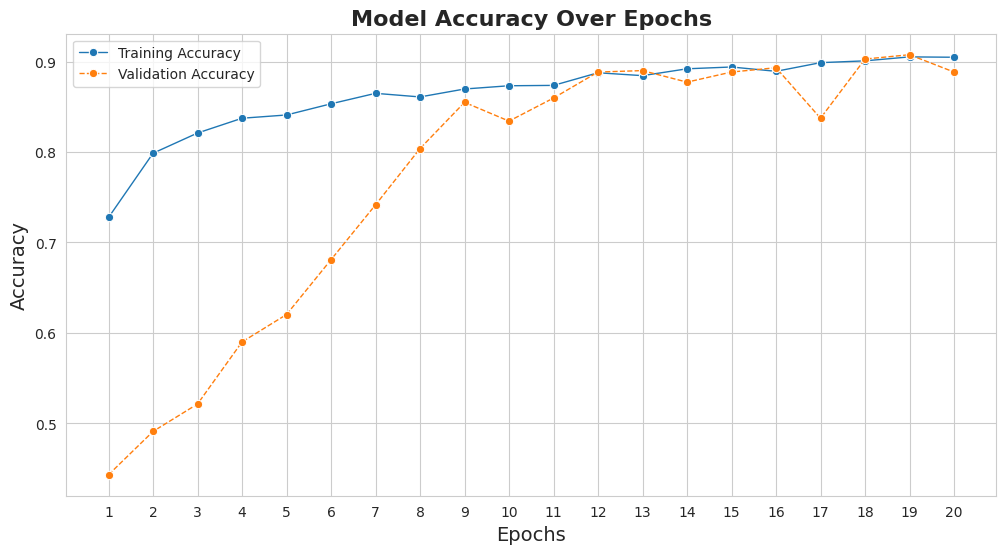

In [39]:
epochs = range(1, len(history.history['accuracy']) + 1)

df = pd.DataFrame({
    "Epoch": epochs,
    "Training Accuracy": history.history['accuracy'],
    "Validation Accuracy": history.history['val_accuracy'],
    "Training Loss": history.history['loss'],
    "Validation Loss": history.history['val_loss']
})

# Set Seaborn Style
sns.set_style("whitegrid")

# Accuracy vs Epochs
plt.figure(figsize=(12, 6))
sns.lineplot(x="Epoch", y="Training Accuracy", data=df, label="Training Accuracy", marker="o", linewidth=1)
sns.lineplot(x="Epoch", y="Validation Accuracy", data=df, label="Validation Accuracy", marker="o", linestyle="--", linewidth=1)

plt.xticks(ticks=epochs)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Model Accuracy Over Epochs", fontsize=16, fontweight="bold")
plt.legend()
plt.show()


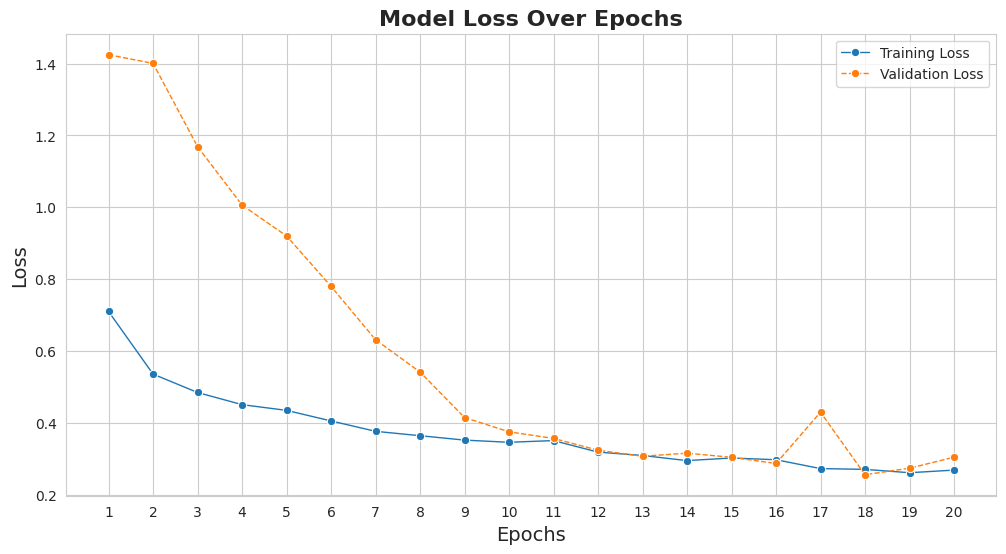

In [40]:

# Loss vs Epochs
plt.figure(figsize=(12, 6))
sns.lineplot(x="Epoch", y="Training Loss", data=df, label="Training Loss", marker="o", linewidth=1)
sns.lineplot(x="Epoch", y="Validation Loss", data=df, label="Validation Loss", marker="o", linestyle="--", linewidth=1)

plt.xticks(ticks=epochs)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Model Loss Over Epochs", fontsize=16, fontweight="bold")
plt.legend()
plt.show()

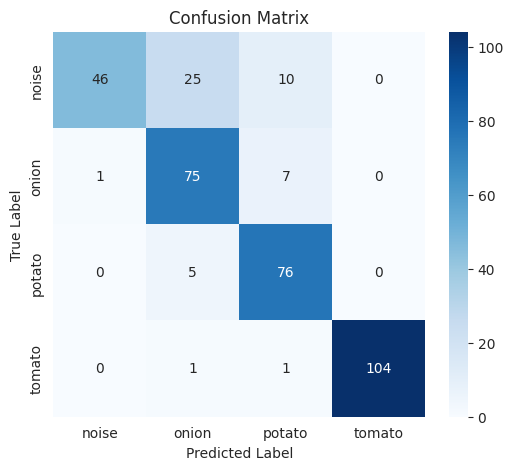

In [41]:
# Function to Plot Confusion Matrix
def plot_confusion_matrix(test_paths, class_names, model):
    y_true, y_pred = [], []

    for class_idx, class_path in enumerate(test_paths):
        paths = [os.path.join(class_path, i) for i in os.listdir(class_path)]

        for path in paths:
            img = tf.keras.utils.load_img(path)
            img = tf.keras.utils.img_to_array(img)
            img = tf.image.resize(img, (256, 256))
            img = np.expand_dims(img, axis=0)

            prediction = model.predict(img, verbose=0)
            predicted_class = tf.argmax(prediction, axis=1).numpy().item()

            y_true.append(class_idx)  # Actual class index
            y_pred.append(predicted_class)  # Predicted class index

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


# Define test paths and class names
test_paths = [noise_test_path, onion_test_path, potato_test_path, tomato_test_path]
class_names = ["noise", "onion", "potato", "tomato"]

# Plot the confusion matrix
plot_confusion_matrix(test_paths, class_names, model_revamp)

1. **Strong Performance for 'Tomato' Class**  
   - The model classified **104 instances** correctly as 'tomato'.  
   - Very few misclassifications: Only 1 as 'noise', 1 as 'onion', and 1 as 'potato'.  

2. **Decent Performance for 'Noise' Class**  
   - **46 instances** correctly classified as 'noise'.  
   - Some misclassifications: 25 as 'onion' and 10 as 'potato'.  
   - The model confuses 'noise' with 'onion' more than other classes.  

3. **Good Performance for 'Onion' and 'Potato' Classes**  
   - 'Onion' was correctly classified **75 times**, but **7 instances were misclassified as 'potato'** and 1 as 'noise'.  
   - 'Potato' was correctly classified **76 times**, but **5 instances were misclassified as 'onion'**.  

4. **General Observation**  
   - The model performs well, especially for 'tomato' with minimal misclassification.  
   - There is some confusion between 'noise' and 'onion'.  
   - The model struggles slightly to differentiate between 'onion' and 'potato'.  

# Transfer Learning
* The models used are
  * VGG-19
  * ResNet
  * MobileNet

## VGG-19

In [42]:
base_model = tf.keras.applications.VGG19(include_top=False, input_shape=(256, 256, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [43]:


# Freeze the layers of the base model to retain pre-trained weights
base_model.trainable = False

# Start building the new classification model using the Functional API
x = base_model.output
x = tf.keras.layers.Rescaling(1./255)(x)  # Rescaling layer, if needed
x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(4, activation="softmax")(x)  # 4 classes in the output layer


In [44]:
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',"Precision","Recall"])

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,172,004 (76.95 MB)

 Trainable params: 147,620 (576.64 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [45]:
# Define Callbacks
log_dir_5 = "logs/VGG19"

In [46]:
# Early Stopping: Monitors 'val_loss' with patience = 5
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [47]:
# Model Checkpoint: Saves the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    "VGG19_best_model.h5",  # Saves the model as 'CNN_best_5.h5'
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [48]:
# TensorBoard Callback: Logs training details for visualization
tensorboard_callback = TensorBoard(log_dir=log_dir_5)

#### Training the model

In [49]:
# Compile Callbacks
callbacks = [early_stopping, model_checkpoint, tensorboard_callback]

# Train Model
history3 = model.fit(
    aug_data,
    validation_data= valid_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - Precision: 0.8204 - Recall: 0.2282 - accuracy: 0.6925 - loss: 0.9988
Epoch 1: val_loss improved from inf to 0.37731, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 73s 679ms/step - Precision: 0.8220 - Recall: 0.2315 - accuracy: 0.6941 - loss: 0.9954 - val_Precision: 0.9420 - val_Recall: 0.8549 - val_accuracy: 0.9123 - val_loss: 0.3773
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - Precision: 0.9548 - Recall: 0.8840 - accuracy: 0.9318 - loss: 0.3283
Epoch 2: val_loss improved from 0.37731 to 0.25822, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 348ms/step - Precision: 0.9547 - Recall: 0.8842 - accuracy: 0.9318 - loss: 0.3278 - val_Precision: 0.9371 - val_Recall: 0.9027 - val_accuracy: 0.9203 - val_loss: 0.2582
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - Precision: 0.9478 - Recall: 0.9128 - accuracy: 0.9382 - loss: 0.2242
Epoch 3: val_loss improved from 0.25822 to 0.20888, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 416ms/step - Precision: 0.9478 - Recall: 0.9129 - accuracy: 0.9382 - loss: 0.2240 - val_Precision: 0.9464 - val_Recall: 0.9298 - val_accuracy: 0.9346 - val_loss: 0.2089
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - Precision: 0.9577 - Recall: 0.9392 - accuracy: 0.9471 - loss: 0.1787
Epoch 4: val_loss improved from 0.20888 to 0.19209, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 404ms/step - Precision: 0.9576 - Recall: 0.9392 - accuracy: 0.9470 - loss: 0.1786 - val_Precision: 0.9481 - val_Recall: 0.9330 - val_accuracy: 0.9394 - val_loss: 0.1921
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - Precision: 0.9649 - Recall: 0.9464 - accuracy: 0.9552 - loss: 0.1425
Epoch 5: val_loss improved from 0.19209 to 0.17597, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 37s 355ms/step - Precision: 0.9649 - Recall: 0.9464 - accuracy: 0.9552 - loss: 0.1425 - val_Precision: 0.9500 - val_Recall: 0.9394 - val_accuracy: 0.9442 - val_loss: 0.1760
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - Precision: 0.9619 - Recall: 0.9514 - accuracy: 0.9567 - loss: 0.1287
Epoch 6: val_loss improved from 0.17597 to 0.17270, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 410ms/step - Precision: 0.9620 - Recall: 0.9514 - accuracy: 0.9567 - loss: 0.1286 - val_Precision: 0.9516 - val_Recall: 0.9410 - val_accuracy: 0.9458 - val_loss: 0.1727
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - Precision: 0.9685 - Recall: 0.9598 - accuracy: 0.9647 - loss: 0.1168
Epoch 7: val_loss improved from 0.17270 to 0.16194, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 405ms/step - Precision: 0.9685 - Recall: 0.9598 - accuracy: 0.9647 - loss: 0.1167 - val_Precision: 0.9517 - val_Recall: 0.9426 - val_accuracy: 0.9490 - val_loss: 0.1619
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - Precision: 0.9754 - Recall: 0.9671 - accuracy: 0.9730 - loss: 0.0945
Epoch 8: val_loss improved from 0.16194 to 0.15774, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 414ms/step - Precision: 0.9754 - Recall: 0.9670 - accuracy: 0.9729 - loss: 0.0946 - val_Precision: 0.9486 - val_Recall: 0.9410 - val_accuracy: 0.9458 - val_loss: 0.1577
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - Precision: 0.9708 - Recall: 0.9615 - accuracy: 0.9689 - loss: 0.0986
Epoch 9: val_loss improved from 0.15774 to 0.15268, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 347ms/step - Precision: 0.9708 - Recall: 0.9615 - accuracy: 0.9689 - loss: 0.0985 - val_Precision: 0.9471 - val_Recall: 0.9426 - val_accuracy: 0.9442 - val_loss: 0.1527
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - Precision: 0.9734 - Recall: 0.9686 - accuracy: 0.9725 - loss: 0.0851
Epoch 10: val_loss improved from 0.15268 to 0.15148, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 353ms/step - Precision: 0.9734 - Recall: 0.9686 - accuracy: 0.9725 - loss: 0.0851 - val_Precision: 0.9488 - val_Recall: 0.9458 - val_accuracy: 0.9490 - val_loss: 0.1515
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - Precision: 0.9836 - Recall: 0.9774 - accuracy: 0.9833 - loss: 0.0774
Epoch 11: val_loss improved from 0.15148 to 0.14962, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 45s 408ms/step - Precision: 0.9835 - Recall: 0.9774 - accuracy: 0.9832 - loss: 0.0774 - val_Precision: 0.9456 - val_Recall: 0.9426 - val_accuracy: 0.9458 - val_loss: 0.1496
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - Precision: 0.9798 - Recall: 0.9788 - accuracy: 0.9790 - loss: 0.0706
Epoch 12: val_loss improved from 0.14962 to 0.14848, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 409ms/step - Precision: 0.9798 - Recall: 0.9788 - accuracy: 0.9790 - loss: 0.0706 - val_Precision: 0.9551 - val_Recall: 0.9506 - val_accuracy: 0.9522 - val_loss: 0.1485
Epoch 13/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - Precision: 0.9828 - Recall: 0.9791 - accuracy: 0.9812 - loss: 0.0676
Epoch 13: val_loss improved from 0.14848 to 0.14836, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 36s 348ms/step - Precision: 0.9828 - Recall: 0.9791 - accuracy: 0.9812 - loss: 0.0676 - val_Precision: 0.9520 - val_Recall: 0.9490 - val_accuracy: 0.9506 - val_loss: 0.1484
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - Precision: 0.9860 - Recall: 0.9820 - accuracy: 0.9823 - loss: 0.0599
Epoch 14: val_loss improved from 0.14836 to 0.14568, saving model to VGG19_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 352ms/step - Precision: 0.9859 - Recall: 0.9820 - accuracy: 0.9823 - loss: 0.0599 - val_Precision: 0.9472 - val_Recall: 0.9442 - val_accuracy: 0.9474 - val_loss: 0.1457
Epoch 15/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - Precision: 0.9859 - Recall: 0.9833 - accuracy: 0.9850 - loss: 0.0576
Epoch 15: val_loss did not improve from 0.14568
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 405ms/step - Precision: 0.9859 - Recall: 0.9833 - accuracy: 0.9850 - loss: 0.0577 - val_Precision: 0.9505 - val_Recall: 0.9490 - val_accuracy: 0.9490 - val_loss: 0.1475
Epoch 16/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - Precision: 0.9882 - Recall: 0.9865 - accuracy: 0.9875 - loss: 0.0533
Epoch 16: val_loss did not improve from 0.14568
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 401ms/step - Precision: 0.9882 - Recall: 0.9865 - accuracy: 0.9875 - loss: 0.0533 - val_Precision: 0.9489 - val_Recall: 0.9474 - val_accuracy: 0.9474 - val_loss: 0.1484
Epoch 17/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - P

In [67]:
final_train_acc = history3.history['accuracy'][-1]  # Last epoch training accuracy
final_val_acc = history3.history['val_accuracy'][-1]  # Last epoch validation accuracy

# Print the results
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Training Accuracy: 0.9900
Final Validation Accuracy: 0.9522


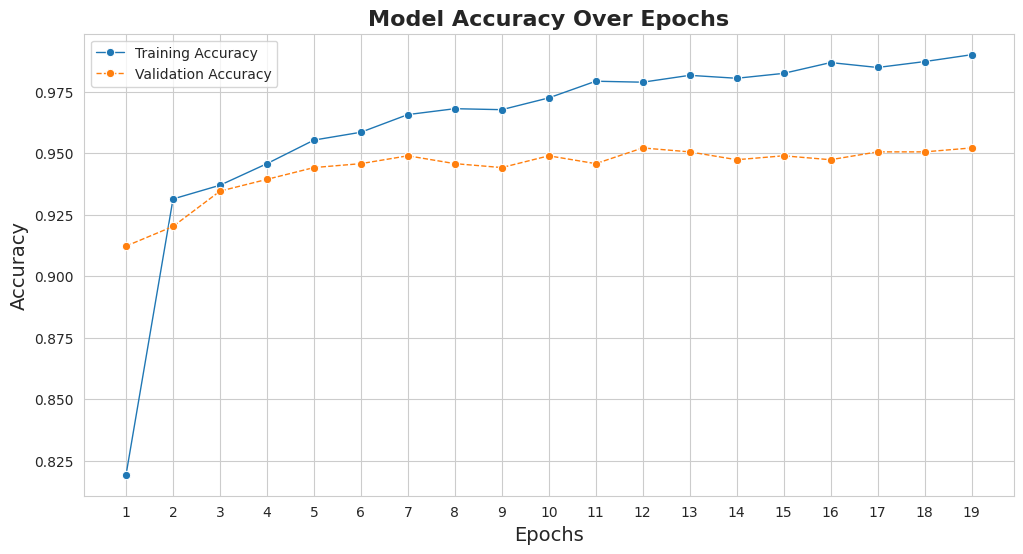

In [51]:
epochs = range(1, len(history3.history['accuracy']) + 1)

df = pd.DataFrame({
    "Epoch": epochs,
    "Training Accuracy": history3.history['accuracy'],
    "Validation Accuracy": history3.history['val_accuracy'],
    "Training Loss": history3.history['loss'],
    "Validation Loss": history3.history['val_loss']
})

# Set Seaborn Style
sns.set_style("whitegrid")

# Accuracy vs Epochs
plt.figure(figsize=(12, 6))
sns.lineplot(x="Epoch", y="Training Accuracy", data=df, label="Training Accuracy", marker="o", linewidth=1)
sns.lineplot(x="Epoch", y="Validation Accuracy", data=df, label="Validation Accuracy", marker="o", linestyle="--", linewidth=1)

plt.xticks(ticks=epochs)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Model Accuracy Over Epochs", fontsize=16, fontweight="bold")
plt.legend()
plt.show()

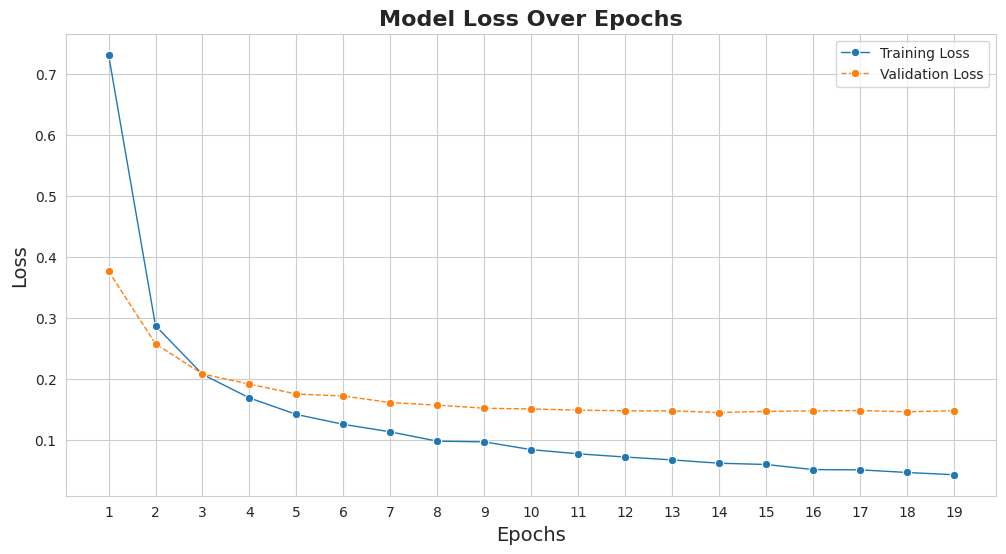

In [52]:
# Loss vs Epochs
plt.figure(figsize=(12, 6))
sns.lineplot(x="Epoch", y="Training Loss", data=df, label="Training Loss", marker="o", linewidth=1)
sns.lineplot(x="Epoch", y="Validation Loss", data=df, label="Validation Loss", marker="o", linestyle="--", linewidth=1)

plt.xticks(ticks=epochs)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Model Loss Over Epochs", fontsize=16, fontweight="bold")
plt.legend()
plt.show()


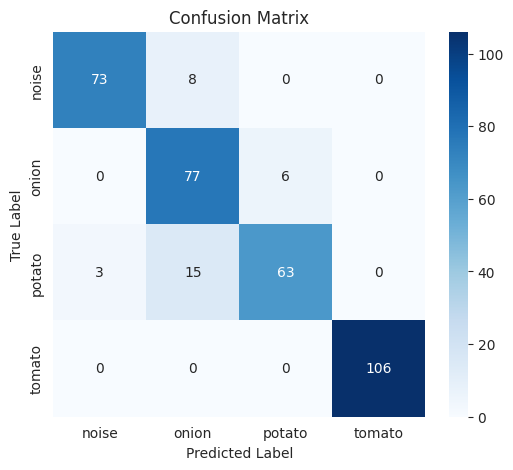

In [53]:
# Function to Plot Confusion Matrix
def plot_confusion_matrix(test_paths, class_names, model):
    y_true, y_pred = [], []

    for class_idx, class_path in enumerate(test_paths):
        if not os.path.exists(class_path):
            print(f"Warning: Path {class_path} does not exist.")
            continue  # Skip if directory does not exist

        images = os.listdir(class_path)
        if len(images) == 0:
            print(f"Warning: No images found in {class_path}")
            continue  # Skip empty directories

        for img_name in images:
            img_path = os.path.join(class_path, img_name)

            # Load and preprocess image
            img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
            img = tf.keras.utils.img_to_array(img)
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            prediction = model.predict(img, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            y_true.append(class_idx)  # Actual class index
            y_pred.append(predicted_class)  # Predicted class index

    if len(y_true) == 0 or len(y_pred) == 0:
        print("Error: No valid test images were processed.")
        return

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Define test paths and class names
test_paths = [noise_test_path, onion_test_path, potato_test_path, tomato_test_path]
class_names = ["noise", "onion", "potato", "tomato"]

# Ensure `model` is used (or rename `model_revamp` if it's the correct model)
plot_confusion_matrix(test_paths, class_names, model)

### **Key Observations:**
- **Noise Class:**  
  - 73 images correctly classified as noise.  
  - 8 misclassified as onions.  
- **Onion Class:**  
  - 77 images correctly classified.  
  - 6 misclassified as potatoes.  
- **Potato Class:**  
  - 63 images correctly classified.  
  - 15 misclassified as onions.  
  - 3 misclassified as noise.  
- **Tomato Class:**  
  - 106 images correctly classified with **0 misclassifications** (perfect prediction for this class).  

### **Insights:**
- The model performs very well for **tomatoes** and **onions** but struggles a bit with distinguishing **potatoes from onions**.  
- There is some confusion between **noise and onions**, which may indicate that some noise images have features resembling onions.  

### **Next Steps for Improvement:**
- Use **data augmentation** to help the model generalize better.
- Adjust **class weights** if certain classes are underrepresented.
- Implement **transfer learning** with pre-trained CNN models like ResNet or EfficientNet.
- Fine-tune **hyperparameters** such as learning rate and batch size.  

## MobileNet

In [70]:



# Load the MobileNetV2 base model with pre-trained weights
base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model to retain pre-trained weights
base_model.trainable = False

x = base_model.output
x = tf.keras.layers.Rescaling(1./255)(x)  # Rescaling layer
x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(4, activation="softmax")(x)








<ipython-input-70-e6df3de2252e>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [71]:
mobilenet_model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile the model
mobilenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "Precision", "Recall"])

# Print model summary
mobilenet_model.summary()

# Define Callbacks
log_dir_mobilenet = "logs/MobileNet"

# Early Stopping: Stops training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Model Checkpoint: Saves the best model based on validation loss
model_checkpoint = ModelCheckpoint(
    "MobileNet_best_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# TensorBoard Callback: Logs training details for visualization
tensorboard_callback = TensorBoard(log_dir=log_dir_mobilenet)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 128, 128, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 128, 128, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 128, 128, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 128, 128, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 128, 128, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 128, 128, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 128, 128, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 128, 128, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 128, 128, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 128, 128, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 129, 129, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 64, 64, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,626,788 (10.02 MB)

 Trainable params: 368,804 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [72]:
# Compile Callbacks
callbacks = [early_stopping, model_checkpoint, tensorboard_callback]

# Train Model
history_mobilenet = mobilenet_model.fit(
    aug_data,
    validation_data=valid_ds,
    epochs=20,
    callbacks=callbacks
)

# Get the final training and validation accuracy
final_train_acc = history_mobilenet.history['accuracy'][-1]
final_val_acc = history_mobilenet.history['val_accuracy'][-1]

# Print the results
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

# Evaluate the model on the test dataset
test_loss, test_accuracy, test_precision, test_recall = mobilenet_model.evaluate(test_data)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - Precision: 0.0253 - Recall: 1.0119e-05 - accuracy: 0.4964 - loss: 1.3274
Epoch 1: val_loss improved from inf to 1.11884, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 38s 305ms/step - Precision: 0.0375 - Recall: 1.4976e-05 - accuracy: 0.4977 - loss: 1.3266 - val_Precision: 0.7500 - val_Recall: 0.0048 - val_accuracy: 0.7544 - val_loss: 1.1188
Epoch 2/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - Precision: 0.8938 - Recall: 0.0782 - accuracy: 0.7516 - loss: 1.0608
Epoch 2: val_loss improved from 1.11884 to 0.87827, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - Precision: 0.8941 - Recall: 0.0805 - accuracy: 0.7514 - loss: 1.0592 - val_Precision: 0.8971 - val_Recall: 0.3892 - val_accuracy: 0.7671 - val_loss: 0.8783
Epoch 3/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - Precision: 0.9057 - Recall: 0.4520 - accuracy: 0.7738 - loss: 0.8250
Epoch 3: val_loss improved from 0.87827 to 0.71207, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - Precision: 0.9056 - Recall: 0.4532 - accuracy: 0.7737 - loss: 0.8242 - val_Precision: 0.8690 - val_Recall: 0.6029 - val_accuracy: 0.7751 - val_loss: 0.7121
Epoch 4/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - Precision: 0.8817 - Recall: 0.6330 - accuracy: 0.8028 - loss: 0.6848
Epoch 4: val_loss improved from 0.71207 to 0.62401, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - Precision: 0.8817 - Recall: 0.6332 - accuracy: 0.8026 - loss: 0.6844 - val_Precision: 0.8612 - val_Recall: 0.6730 - val_accuracy: 0.7815 - val_loss: 0.6240
Epoch 5/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - Precision: 0.8832 - Recall: 0.7058 - accuracy: 0.8114 - loss: 0.5976
Epoch 5: val_loss improved from 0.62401 to 0.56659, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - Precision: 0.8829 - Recall: 0.7056 - accuracy: 0.8110 - loss: 0.5976 - val_Precision: 0.8531 - val_Recall: 0.7129 - val_accuracy: 0.7927 - val_loss: 0.5666
Epoch 6/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - Precision: 0.8778 - Recall: 0.7392 - accuracy: 0.8167 - loss: 0.5394
Epoch 6: val_loss improved from 0.56659 to 0.52855, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Precision: 0.8775 - Recall: 0.7390 - accuracy: 0.8166 - loss: 0.5394 - val_Precision: 0.8487 - val_Recall: 0.7337 - val_accuracy: 0.8086 - val_loss: 0.5286
Epoch 7/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - Precision: 0.8772 - Recall: 0.7507 - accuracy: 0.8113 - loss: 0.5188
Epoch 7: val_loss improved from 0.52855 to 0.50691, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - Precision: 0.8771 - Recall: 0.7508 - accuracy: 0.8115 - loss: 0.5186 - val_Precision: 0.8481 - val_Recall: 0.7480 - val_accuracy: 0.8134 - val_loss: 0.5069
Epoch 8/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - Precision: 0.8836 - Recall: 0.7716 - accuracy: 0.8327 - loss: 0.4639
Epoch 8: val_loss improved from 0.50691 to 0.48906, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - Precision: 0.8832 - Recall: 0.7712 - accuracy: 0.8325 - loss: 0.4642 - val_Precision: 0.8503 - val_Recall: 0.7608 - val_accuracy: 0.8214 - val_loss: 0.4891
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - Precision: 0.8726 - Recall: 0.7789 - accuracy: 0.8369 - loss: 0.4562
Epoch 9: val_loss improved from 0.48906 to 0.47558, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - Precision: 0.8725 - Recall: 0.7788 - accuracy: 0.8368 - loss: 0.4563 - val_Precision: 0.8564 - val_Recall: 0.7703 - val_accuracy: 0.8230 - val_loss: 0.4756
Epoch 10/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - Precision: 0.8853 - Recall: 0.7974 - accuracy: 0.8480 - loss: 0.4317
Epoch 10: val_loss improved from 0.47558 to 0.46218, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - Precision: 0.8850 - Recall: 0.7973 - accuracy: 0.8478 - loss: 0.4317 - val_Precision: 0.8512 - val_Recall: 0.7847 - val_accuracy: 0.8278 - val_loss: 0.4622
Epoch 11/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - Precision: 0.8863 - Recall: 0.8095 - accuracy: 0.8506 - loss: 0.4095
Epoch 11: val_loss improved from 0.46218 to 0.45783, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - Precision: 0.8862 - Recall: 0.8093 - accuracy: 0.8505 - loss: 0.4098 - val_Precision: 0.8497 - val_Recall: 0.7847 - val_accuracy: 0.8293 - val_loss: 0.4578
Epoch 12/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - Precision: 0.8897 - Recall: 0.8213 - accuracy: 0.8611 - loss: 0.3974
Epoch 12: val_loss improved from 0.45783 to 0.44481, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - Precision: 0.8895 - Recall: 0.8209 - accuracy: 0.8608 - loss: 0.3976 - val_Precision: 0.8537 - val_Recall: 0.7911 - val_accuracy: 0.8341 - val_loss: 0.4448
Epoch 13/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - Precision: 0.8868 - Recall: 0.8121 - accuracy: 0.8571 - loss: 0.3959
Epoch 13: val_loss improved from 0.44481 to 0.43694, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - Precision: 0.8865 - Recall: 0.8120 - accuracy: 0.8568 - loss: 0.3960 - val_Precision: 0.8537 - val_Recall: 0.8006 - val_accuracy: 0.8341 - val_loss: 0.4369
Epoch 14/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - Precision: 0.8838 - Recall: 0.8231 - accuracy: 0.8520 - loss: 0.3851
Epoch 14: val_loss improved from 0.43694 to 0.43352, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - Precision: 0.8838 - Recall: 0.8230 - accuracy: 0.8520 - loss: 0.3851 - val_Precision: 0.8615 - val_Recall: 0.8038 - val_accuracy: 0.8373 - val_loss: 0.4335
Epoch 15/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - Precision: 0.8852 - Recall: 0.8356 - accuracy: 0.8590 - loss: 0.3716
Epoch 15: val_loss improved from 0.43352 to 0.42969, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - Precision: 0.8852 - Recall: 0.8355 - accuracy: 0.8590 - loss: 0.3715 - val_Precision: 0.8625 - val_Recall: 0.8102 - val_accuracy: 0.8373 - val_loss: 0.4297
Epoch 16/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - Precision: 0.8891 - Recall: 0.8293 - accuracy: 0.8567 - loss: 0.3689
Epoch 16: val_loss improved from 0.42969 to 0.42353, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - Precision: 0.8890 - Recall: 0.8293 - accuracy: 0.8567 - loss: 0.3688 - val_Precision: 0.8605 - val_Recall: 0.8070 - val_accuracy: 0.8389 - val_loss: 0.4235
Epoch 17/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - Precision: 0.8898 - Recall: 0.8393 - accuracy: 0.8681 - loss: 0.3539
Epoch 17: val_loss improved from 0.42353 to 0.42027, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - Precision: 0.8897 - Recall: 0.8391 - accuracy: 0.8680 - loss: 0.3539 - val_Precision: 0.8622 - val_Recall: 0.8182 - val_accuracy: 0.8437 - val_loss: 0.4203
Epoch 18/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - Precision: 0.8969 - Recall: 0.8540 - accuracy: 0.8775 - loss: 0.3300
Epoch 18: val_loss improved from 0.42027 to 0.41320, saving model to MobileNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - Precision: 0.8967 - Recall: 0.8537 - accuracy: 0.8773 - loss: 0.3302 - val_Precision: 0.8655 - val_Recall: 0.8214 - val_accuracy: 0.8533 - val_loss: 0.4132
Epoch 19/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - Precision: 0.8927 - Recall: 0.8488 - accuracy: 0.8733 - loss: 0.3387
Epoch 19: val_loss did not improve from 0.41320
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - Precision: 0.8927 - Recall: 0.8487 - accuracy: 0.8733 - loss: 0.3387 - val_Precision: 0.8602 - val_Recall: 0.8246 - val_accuracy: 0.8501 - val_loss: 0.4133
Epoch 20/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - Precision: 0.9035 - Recall: 0.8611 - accuracy: 0.8817 - loss: 0.3180
Epoch 20: val_loss did not improve from 0.41320
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - Precision: 0.9033 - Recall: 0.8608 - accuracy: 0.8815 - loss: 0.3184 - val_Precision: 0.8629 - val_Recall: 0.8230 - val_accuracy: 0.8437 - val_loss: 0.4141
Final Training Accuracy: 0.8724
Final Validation Accuracy:

In [73]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Test Loss: 0.5351
Test Accuracy: 0.7835
Test Precision: 0.8127
Test Recall: 0.7664


## ResNet

In [54]:
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(256, 256, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [55]:


# Freeze the layers of the base model to retain pre-trained weights
base_model.trainable = False

# Start building the new classification model using the Functional API
x = base_model.output
x = tf.keras.layers.Rescaling(1./255)(x)  # Rescaling layer, if needed
x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(4, activation="softmax")(x)  # 4 classes in the output layer


In [56]:
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',"Precision","Recall"])

# Print model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,177,700 (92.23 MB)

 Trainable params: 589,988 (2.25 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [57]:
# Define Callbacks
log_dir_6 = "logs/RESNET"

In [58]:
# Early Stopping: Monitors 'val_loss' with patience = 5
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [59]:
# Model Checkpoint: Saves the best model based on val_loss
model_checkpoint = ModelCheckpoint(
    "ResNet_best_model.h5",  # Saves the model as 'CNN_best_5.h5'
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [60]:
# TensorBoard Callback: Logs training details for visualization
tensorboard_callback = TensorBoard(log_dir=log_dir_6)

In [61]:
# Compile Callbacks
callbacks = [early_stopping, model_checkpoint, tensorboard_callback]

# Train Model
history4 = model.fit(
    aug_data,
    validation_data= valid_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - Precision: 0.7992 - Recall: 0.2044 - accuracy: 0.7507 - loss: 1.0141
Epoch 1: val_loss improved from inf to 0.35552, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 335ms/step - Precision: 0.8014 - Recall: 0.2078 - accuracy: 0.7520 - loss: 1.0107 - val_Precision: 0.9624 - val_Recall: 0.8979 - val_accuracy: 0.9282 - val_loss: 0.3555
Epoch 2/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - Precision: 0.9660 - Recall: 0.9069 - accuracy: 0.9459 - loss: 0.3012
Epoch 2: val_loss improved from 0.35552 to 0.20296, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - Precision: 0.9661 - Recall: 0.9073 - accuracy: 0.9459 - loss: 0.3003 - val_Precision: 0.9527 - val_Recall: 0.9314 - val_accuracy: 0.9474 - val_loss: 0.2030
Epoch 3/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - Precision: 0.9708 - Recall: 0.9483 - accuracy: 0.9587 - loss: 0.1731
Epoch 3: val_loss improved from 0.20296 to 0.16088, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - Precision: 0.9708 - Recall: 0.9484 - accuracy: 0.9588 - loss: 0.1727 - val_Precision: 0.9562 - val_Recall: 0.9394 - val_accuracy: 0.9537 - val_loss: 0.1609
Epoch 4/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - Precision: 0.9797 - Recall: 0.9684 - accuracy: 0.9740 - loss: 0.1237
Epoch 4: val_loss improved from 0.16088 to 0.13308, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - Precision: 0.9797 - Recall: 0.9684 - accuracy: 0.9739 - loss: 0.1236 - val_Precision: 0.9645 - val_Recall: 0.9537 - val_accuracy: 0.9601 - val_loss: 0.1331
Epoch 5/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - Precision: 0.9786 - Recall: 0.9649 - accuracy: 0.9685 - loss: 0.1028
Epoch 5: val_loss improved from 0.13308 to 0.13032, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - Precision: 0.9786 - Recall: 0.9651 - accuracy: 0.9687 - loss: 0.1026 - val_Precision: 0.9677 - val_Recall: 0.9569 - val_accuracy: 0.9617 - val_loss: 0.1303
Epoch 6/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - Precision: 0.9858 - Recall: 0.9738 - accuracy: 0.9824 - loss: 0.0802
Epoch 6: val_loss improved from 0.13032 to 0.11350, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - Precision: 0.9857 - Recall: 0.9738 - accuracy: 0.9823 - loss: 0.0802 - val_Precision: 0.9679 - val_Recall: 0.9633 - val_accuracy: 0.9649 - val_loss: 0.1135
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - Precision: 0.9894 - Recall: 0.9845 - accuracy: 0.9877 - loss: 0.0660
Epoch 7: val_loss improved from 0.11350 to 0.11296, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - Precision: 0.9894 - Recall: 0.9845 - accuracy: 0.9877 - loss: 0.0660 - val_Precision: 0.9712 - val_Recall: 0.9665 - val_accuracy: 0.9665 - val_loss: 0.1130
Epoch 8/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - Precision: 0.9901 - Recall: 0.9863 - accuracy: 0.9886 - loss: 0.0593
Epoch 8: val_loss did not improve from 0.11296
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - Precision: 0.9900 - Recall: 0.9862 - accuracy: 0.9885 - loss: 0.0592 - val_Precision: 0.9663 - val_Recall: 0.9617 - val_accuracy: 0.9633 - val_loss: 0.1155
Epoch 9/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - Precision: 0.9924 - Recall: 0.9901 - accuracy: 0.9922 - loss: 0.0486
Epoch 9: val_loss improved from 0.11296 to 0.10502, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - Precision: 0.9923 - Recall: 0.9901 - accuracy: 0.9921 - loss: 0.0487 - val_Precision: 0.9649 - val_Recall: 0.9633 - val_accuracy: 0.9633 - val_loss: 0.1050
Epoch 10/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - Precision: 0.9930 - Recall: 0.9911 - accuracy: 0.9923 - loss: 0.0448
Epoch 10: val_loss improved from 0.10502 to 0.10334, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - Precision: 0.9929 - Recall: 0.9910 - accuracy: 0.9922 - loss: 0.0449 - val_Precision: 0.9696 - val_Recall: 0.9649 - val_accuracy: 0.9649 - val_loss: 0.1033
Epoch 11/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - Precision: 0.9967 - Recall: 0.9932 - accuracy: 0.9952 - loss: 0.0412
Epoch 11: val_loss improved from 0.10334 to 0.10182, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - Precision: 0.9967 - Recall: 0.9932 - accuracy: 0.9951 - loss: 0.0412 - val_Precision: 0.9696 - val_Recall: 0.9665 - val_accuracy: 0.9665 - val_loss: 0.1018
Epoch 12/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - Precision: 0.9944 - Recall: 0.9927 - accuracy: 0.9934 - loss: 0.0340
Epoch 12: val_loss improved from 0.10182 to 0.09319, saving model to ResNet_best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - Precision: 0.9944 - Recall: 0.9926 - accuracy: 0.9933 - loss: 0.0341 - val_Precision: 0.9696 - val_Recall: 0.9665 - val_accuracy: 0.9681 - val_loss: 0.0932
Epoch 13/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - Precision: 0.9951 - Recall: 0.9951 - accuracy: 0.9951 - loss: 0.0326
Epoch 13: val_loss did not improve from 0.09319
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step - Precision: 0.9951 - Recall: 0.9950 - accuracy: 0.9951 - loss: 0.0326 - val_Precision: 0.9696 - val_Recall: 0.9665 - val_accuracy: 0.9681 - val_loss: 0.0949
Epoch 14/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - Precision: 0.9969 - Recall: 0.9965 - accuracy: 0.9965 - loss: 0.0275
Epoch 14: val_loss did not improve from 0.09319
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - Precision: 0.9969 - Recall: 0.9965 - accuracy: 0.9965 - loss: 0.0275 - val_Precision: 0.9696 - val_Recall: 0.9665 - val_accuracy: 0.9665 - val_loss: 0.0977
Epoch 15/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - P

79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - Precision: 0.9956 - Recall: 0.9950 - accuracy: 0.9950 - loss: 0.0203 - val_Precision: 0.9697 - val_Recall: 0.9697 - val_accuracy: 0.9697 - val_loss: 0.0923
Epoch 18/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - Precision: 0.9979 - Recall: 0.9971 - accuracy: 0.9979 - loss: 0.0182
Epoch 18: val_loss did not improve from 0.09228
79/79 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - Precision: 0.9979 - Recall: 0.9970 - accuracy: 0.9979 - loss: 0.0183 - val_Precision: 0.9681 - val_Recall: 0.9681 - val_accuracy: 0.9681 - val_loss: 0.0976
Epoch 19/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - Precision: 0.9992 - Recall: 0.9992 - accuracy: 0.9992 - loss: 0.0176
Epoch 19: val_loss did not improve from 0.09228
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - Precision: 0.9992 - Recall: 0.9992 - accuracy: 0.9992 - loss: 0.0175 - val_Precision: 0.9712 - val_Recall: 0.9681 - val_accuracy: 0.9697 - val_loss: 0.0996
Epoch 20/20
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - P

In [62]:
# Get the final training and validation accuracy for history4
final_train_acc = history4.history['accuracy'][-1]  # Last epoch training accuracy
final_val_acc = history4.history['val_accuracy'][-1]  # Last epoch validation accuracy

# Print the results
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

Final Training Accuracy: 0.9968
Final Validation Accuracy: 0.9681


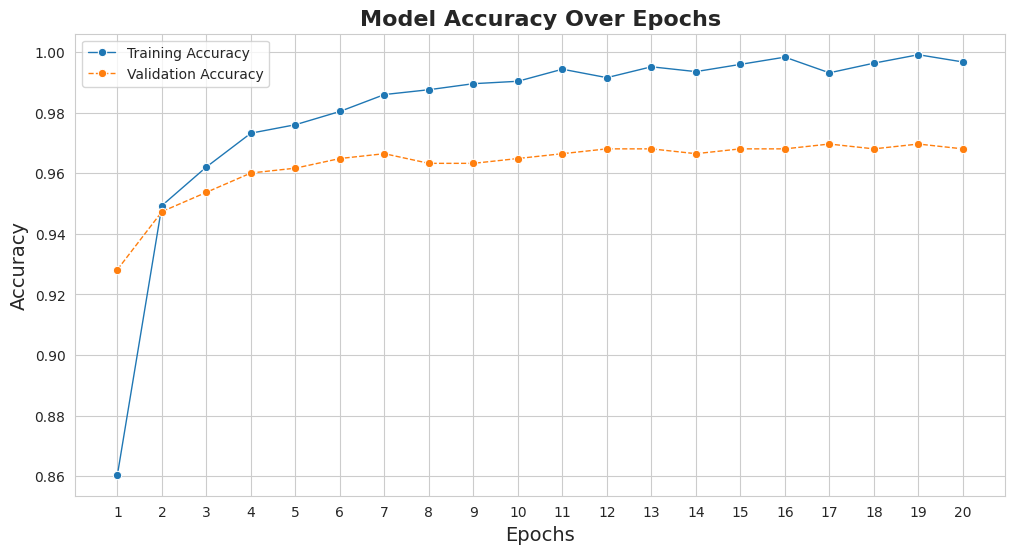

In [63]:
epochs = range(1, len(history4.history['accuracy']) + 1)

# Create DataFrame for visualization
df = pd.DataFrame({
    "Epoch": epochs,
    "Training Accuracy": history4.history['accuracy'],
    "Validation Accuracy": history4.history['val_accuracy'],
    "Training Loss": history4.history['loss'],
    "Validation Loss": history4.history['val_loss']
})

# Set Seaborn Style
sns.set_style("whitegrid")

# Accuracy vs Epochs
plt.figure(figsize=(12, 6))
sns.lineplot(x="Epoch", y="Training Accuracy", data=df, label="Training Accuracy", marker="o", linewidth=1)
sns.lineplot(x="Epoch", y="Validation Accuracy", data=df, label="Validation Accuracy", marker="o", linestyle="--", linewidth=1)

plt.xticks(ticks=epochs)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Model Accuracy Over Epochs", fontsize=16, fontweight="bold")
plt.legend()
plt.show()


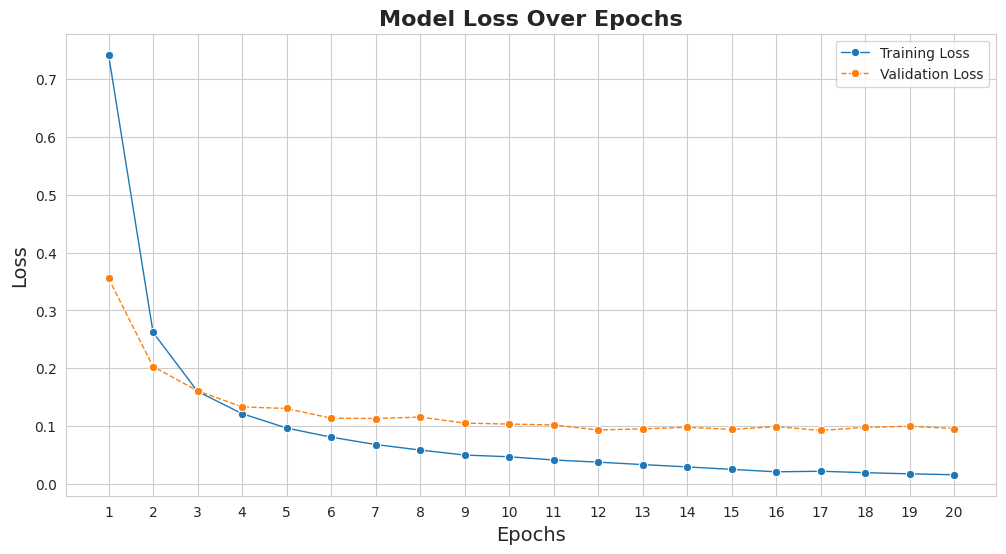

In [64]:
# Loss vs Epochs
plt.figure(figsize=(12, 6))
sns.lineplot(x="Epoch", y="Training Loss", data=df, label="Training Loss", marker="o", linewidth=1)
sns.lineplot(x="Epoch", y="Validation Loss", data=df, label="Validation Loss", marker="o", linestyle="--", linewidth=1)

plt.xticks(ticks=epochs)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Model Loss Over Epochs", fontsize=16, fontweight="bold")
plt.legend()
plt.show()

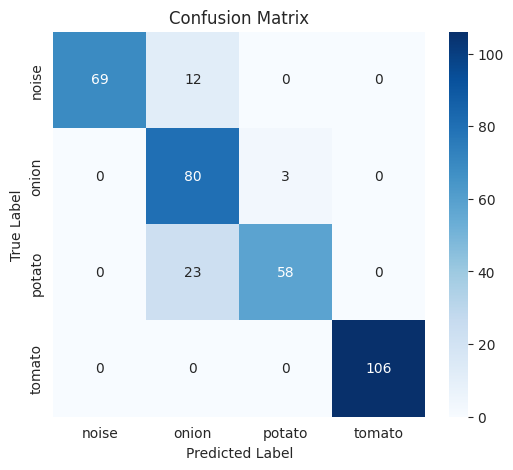

In [65]:

# Function to Plot Confusion Matrix
def plot_confusion_matrix(test_paths, class_names, model):
    y_true, y_pred = [], []

    for class_idx, class_path in enumerate(test_paths):
        if not os.path.exists(class_path):
            print(f"Warning: Path {class_path} does not exist.")
            continue  # Skip if directory does not exist

        images = os.listdir(class_path)
        if len(images) == 0:
            print(f"Warning: No images found in {class_path}")
            continue  # Skip empty directories

        for img_name in images:
            img_path = os.path.join(class_path, img_name)

            # Load and preprocess image
            img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
            img = tf.keras.utils.img_to_array(img)
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            prediction = model.predict(img, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            y_true.append(class_idx)  # Actual class index
            y_pred.append(predicted_class)  # Predicted class index

    if len(y_true) == 0 or len(y_pred) == 0:
        print("Error: No valid test images were processed.")
        return

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Define test paths and class names
test_paths = [noise_test_path, onion_test_path, potato_test_path, tomato_test_path]
class_names = ["noise", "onion", "potato", "tomato"]

# Ensure `model` is used (or rename `model_revamp` if it's the correct model)
plot_confusion_matrix(test_paths, class_names, model)

1. **Excellent Performance for 'Tomato' Class**  
   - The model classified **106 instances** correctly as 'tomato'.  
   - No misclassifications, indicating perfect classification for 'tomato'.  

2. **Good Performance for 'Noise' Class**  
   - **69 instances** correctly classified as 'noise'.  
   - Some misclassifications: **12 instances were classified as 'onion'**.  

3. **Moderate Performance for 'Onion' and 'Potato' Classes**  
   - 'Onion' was correctly classified **80 times**, but **3 instances were misclassified as 'potato'**.  
   - 'Potato' was correctly classified **58 times**, but **23 instances were misclassified as 'onion'**, showing a significant confusion between 'potato' and 'onion'.  

4. **General Observations**  
   - The model performs **exceptionally well** for 'tomato' with zero misclassifications.  
   - The confusion between 'potato' and 'onion' suggests that these classes have overlapping features.  
   - 'Noise' is sometimes misclassified as 'onion', indicating some similarity between these classes in the model’s perception.

# **Model Performance Comparison**

| Model  | Training Accuracy | Validation Accuracy |
|--------|------------------|--------------------|
| **VGG19**  | 0.9900  | 0.9522  |
| **ResNet** | 0.9968  | 0.9681  |

* ResNet is giving me better validation and training accuracy also it is giving me better Recall and Precision.
* Hence this is my final model.

In [69]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - Precision: 0.9103 - Recall: 0.9072 - accuracy: 0.9105 - loss: 0.3612
Test Loss: 0.3431
Test Accuracy: 0.9003
Test Precision: 0.9000
Test Recall: 0.8974


* The final test accuracy is 90%